# Training visualization - 2020 March 28

In [1]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [2]:
DATASET_PATH = 'datasets/dataset_sample_v7.npz'
BATCH_SIZE = 8
NUM_WORKERS = 4

# Model parameters
d_model = 48 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 4 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 24 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 38 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Load dataset

In [3]:
ozeDataset = OzeDataset(DATASET_PATH)

dataloader = DataLoader(ozeDataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS,
                          pin_memory=False
                         )

## Load network

In [4]:
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
net.load_state_dict(torch.load('models/model_2020_03_10__231146.pth'))
_ = net.eval()

## Evaluate on the test dataset

In [5]:
predictions = np.empty(shape=(len(dataloader.dataset), 168, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader, total=len(dataloader)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 125/125 [00:06<00:00, 18.72it/s]


### Plot results on a sample

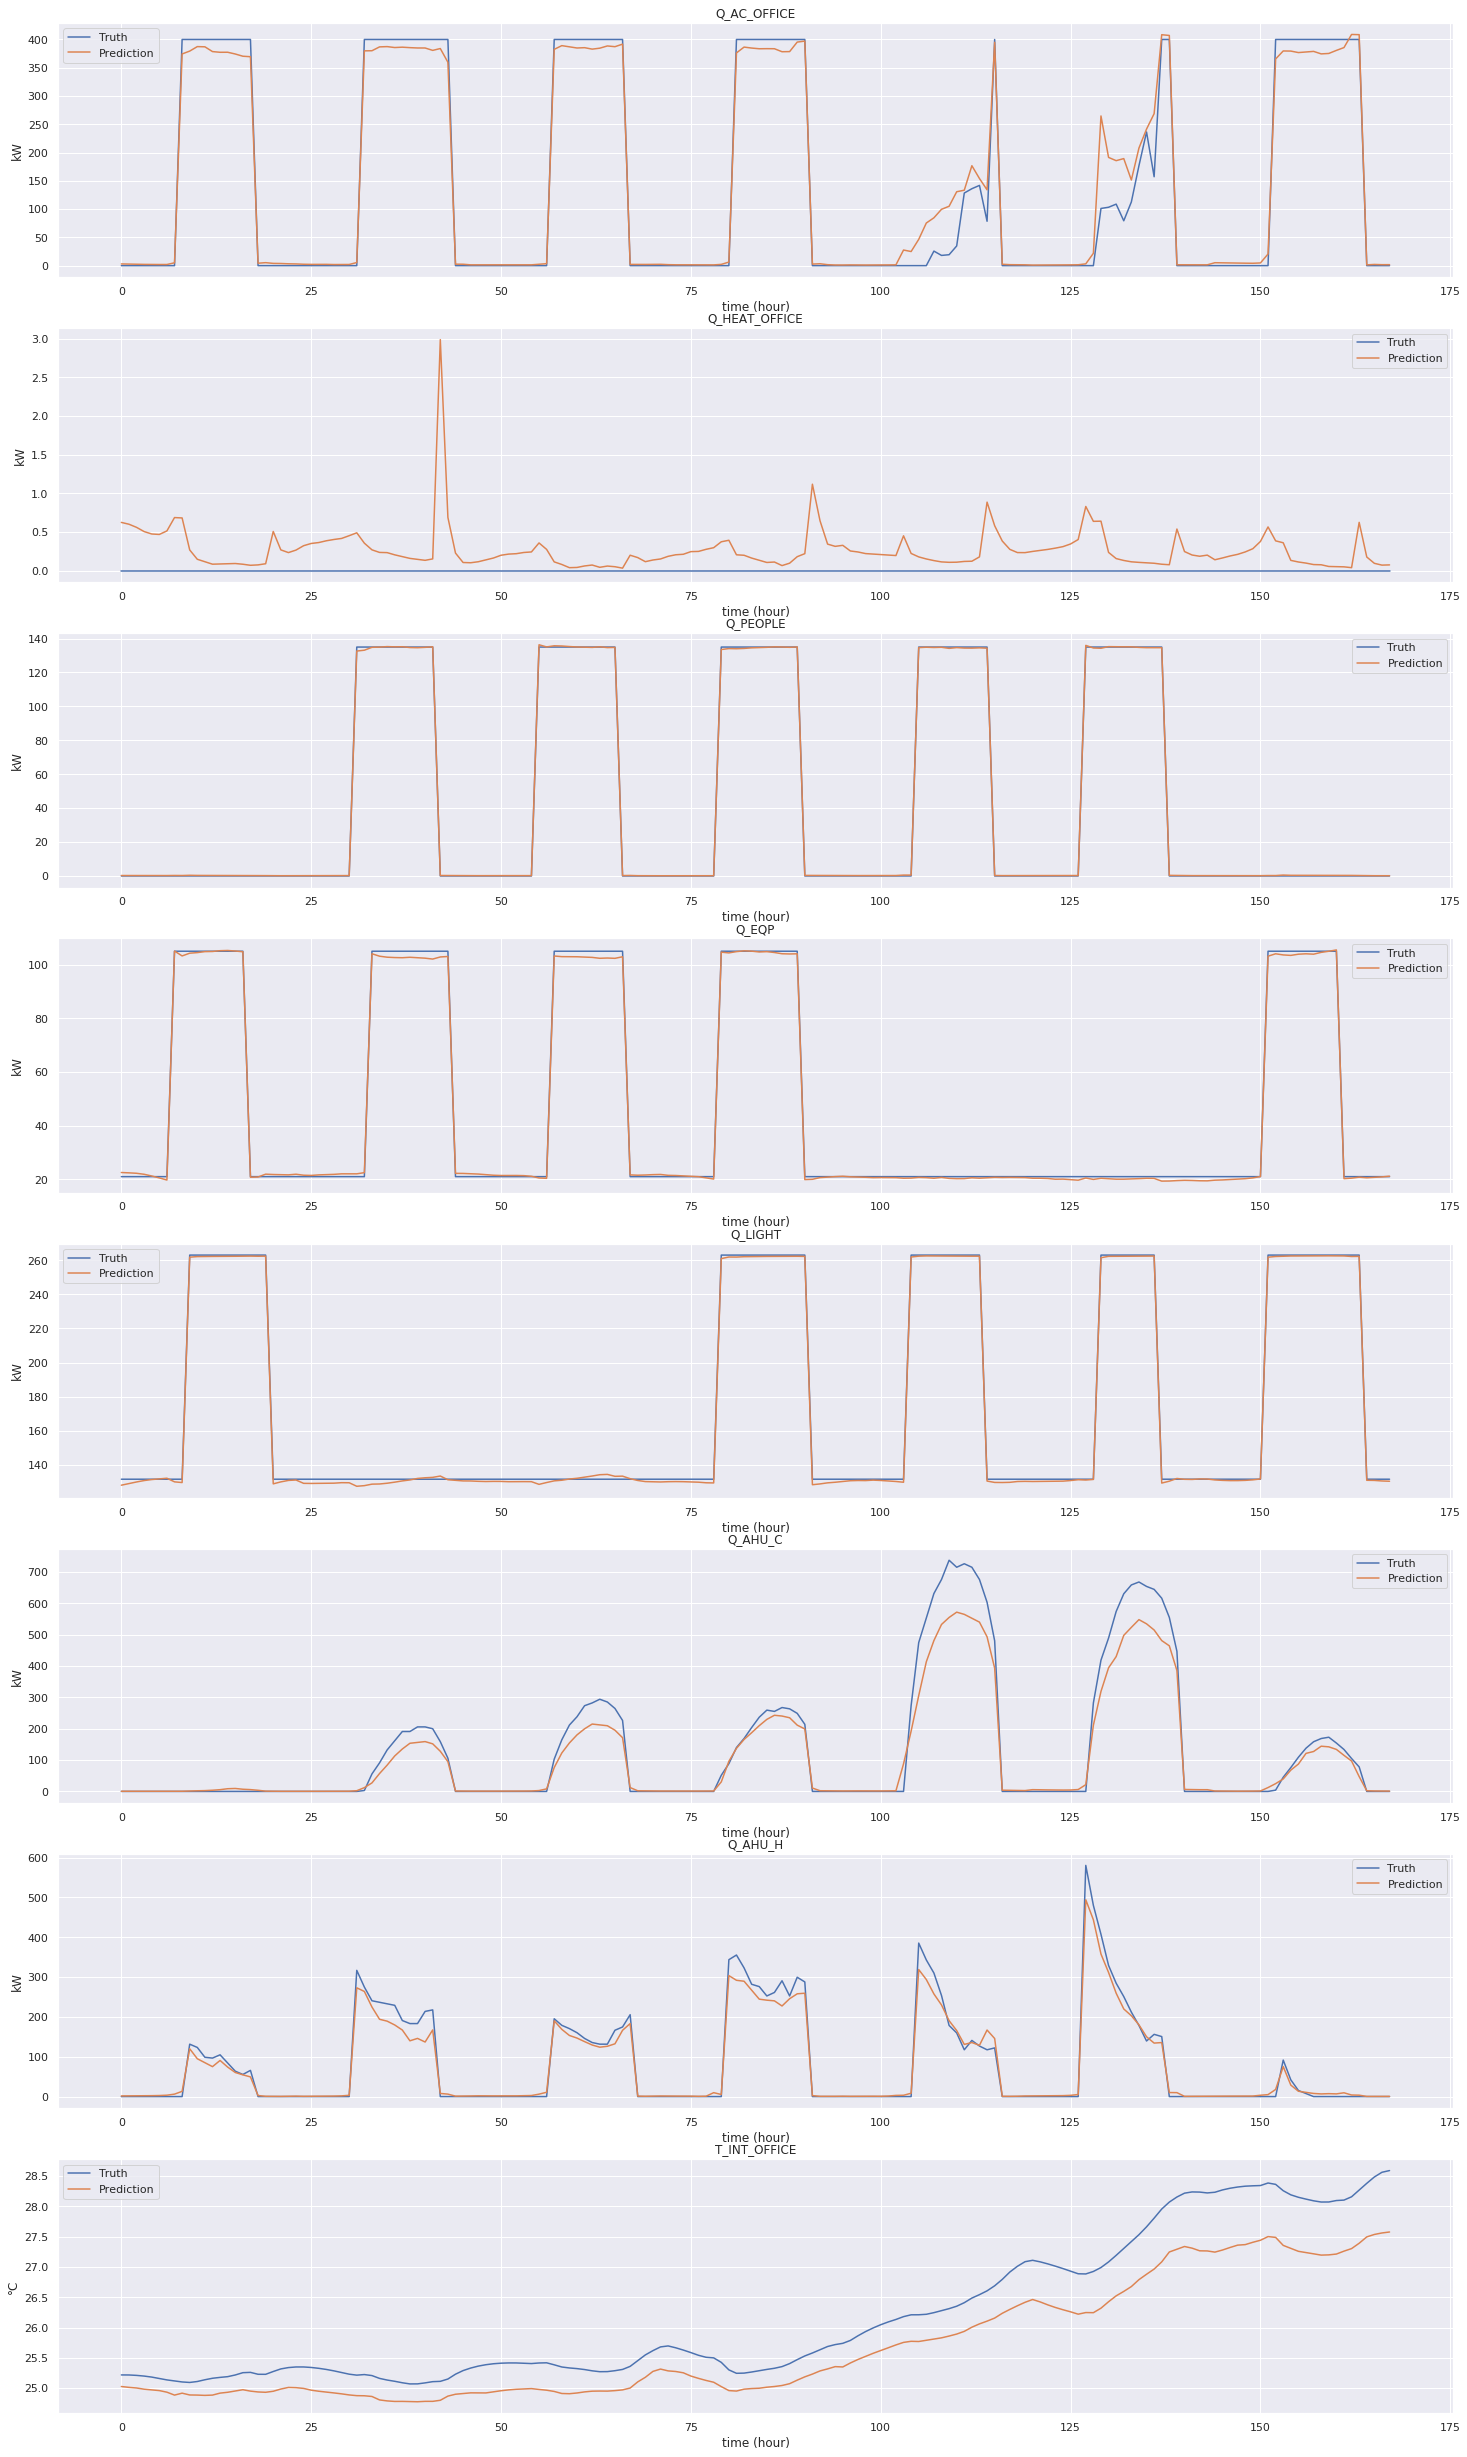

In [6]:
map_plot_function(ozeDataset, predictions, plot_visual_sample)

### Plot encoding attention map

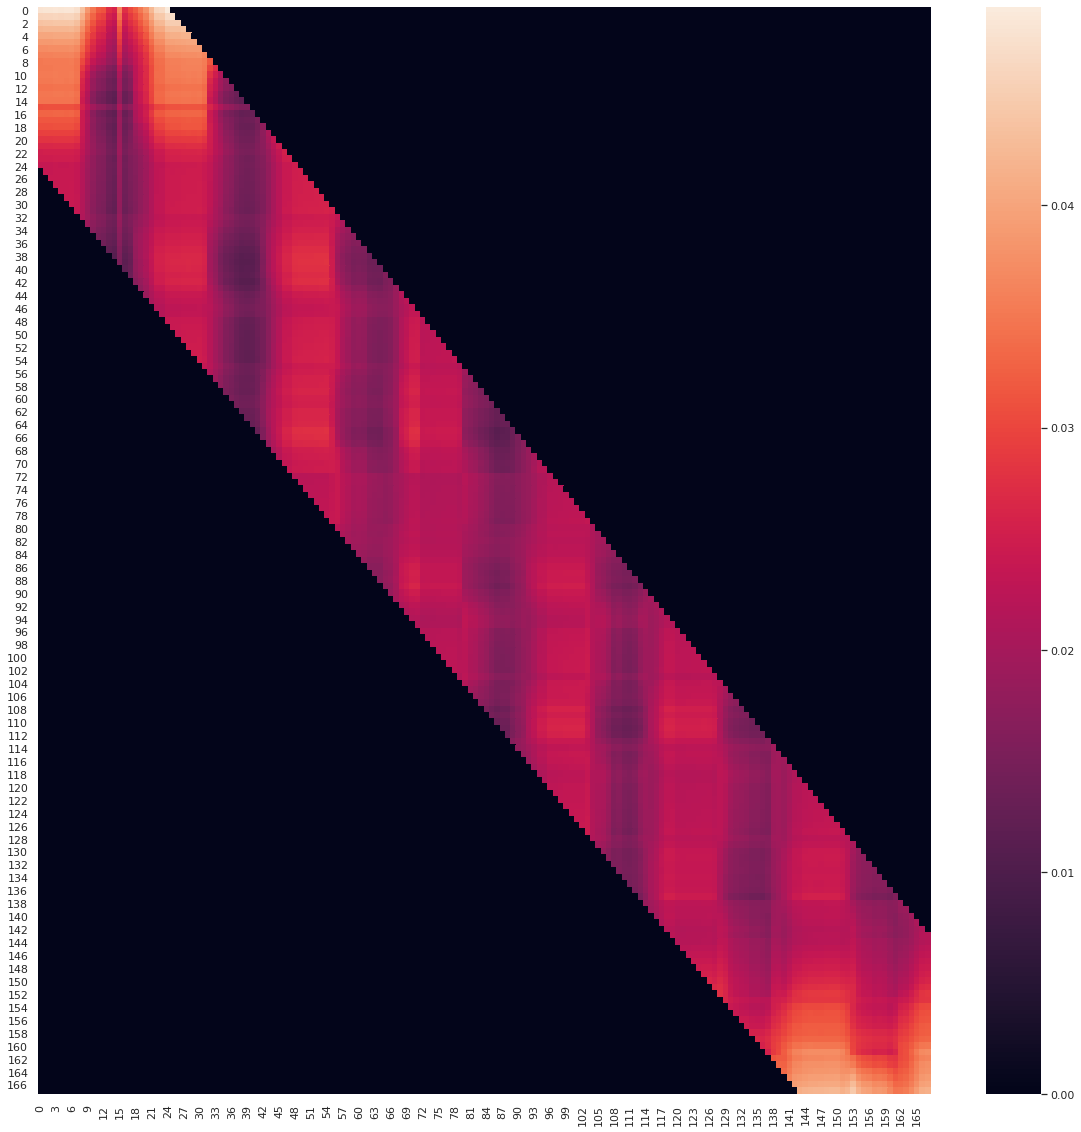

In [7]:
# Select first encoding layer
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu()

# Plot
plt.figure(figsize=(20, 20))
sns.heatmap(attn_map)
plt.savefig("attention_map")

### Plot dataset and prediction distributions for consumptions

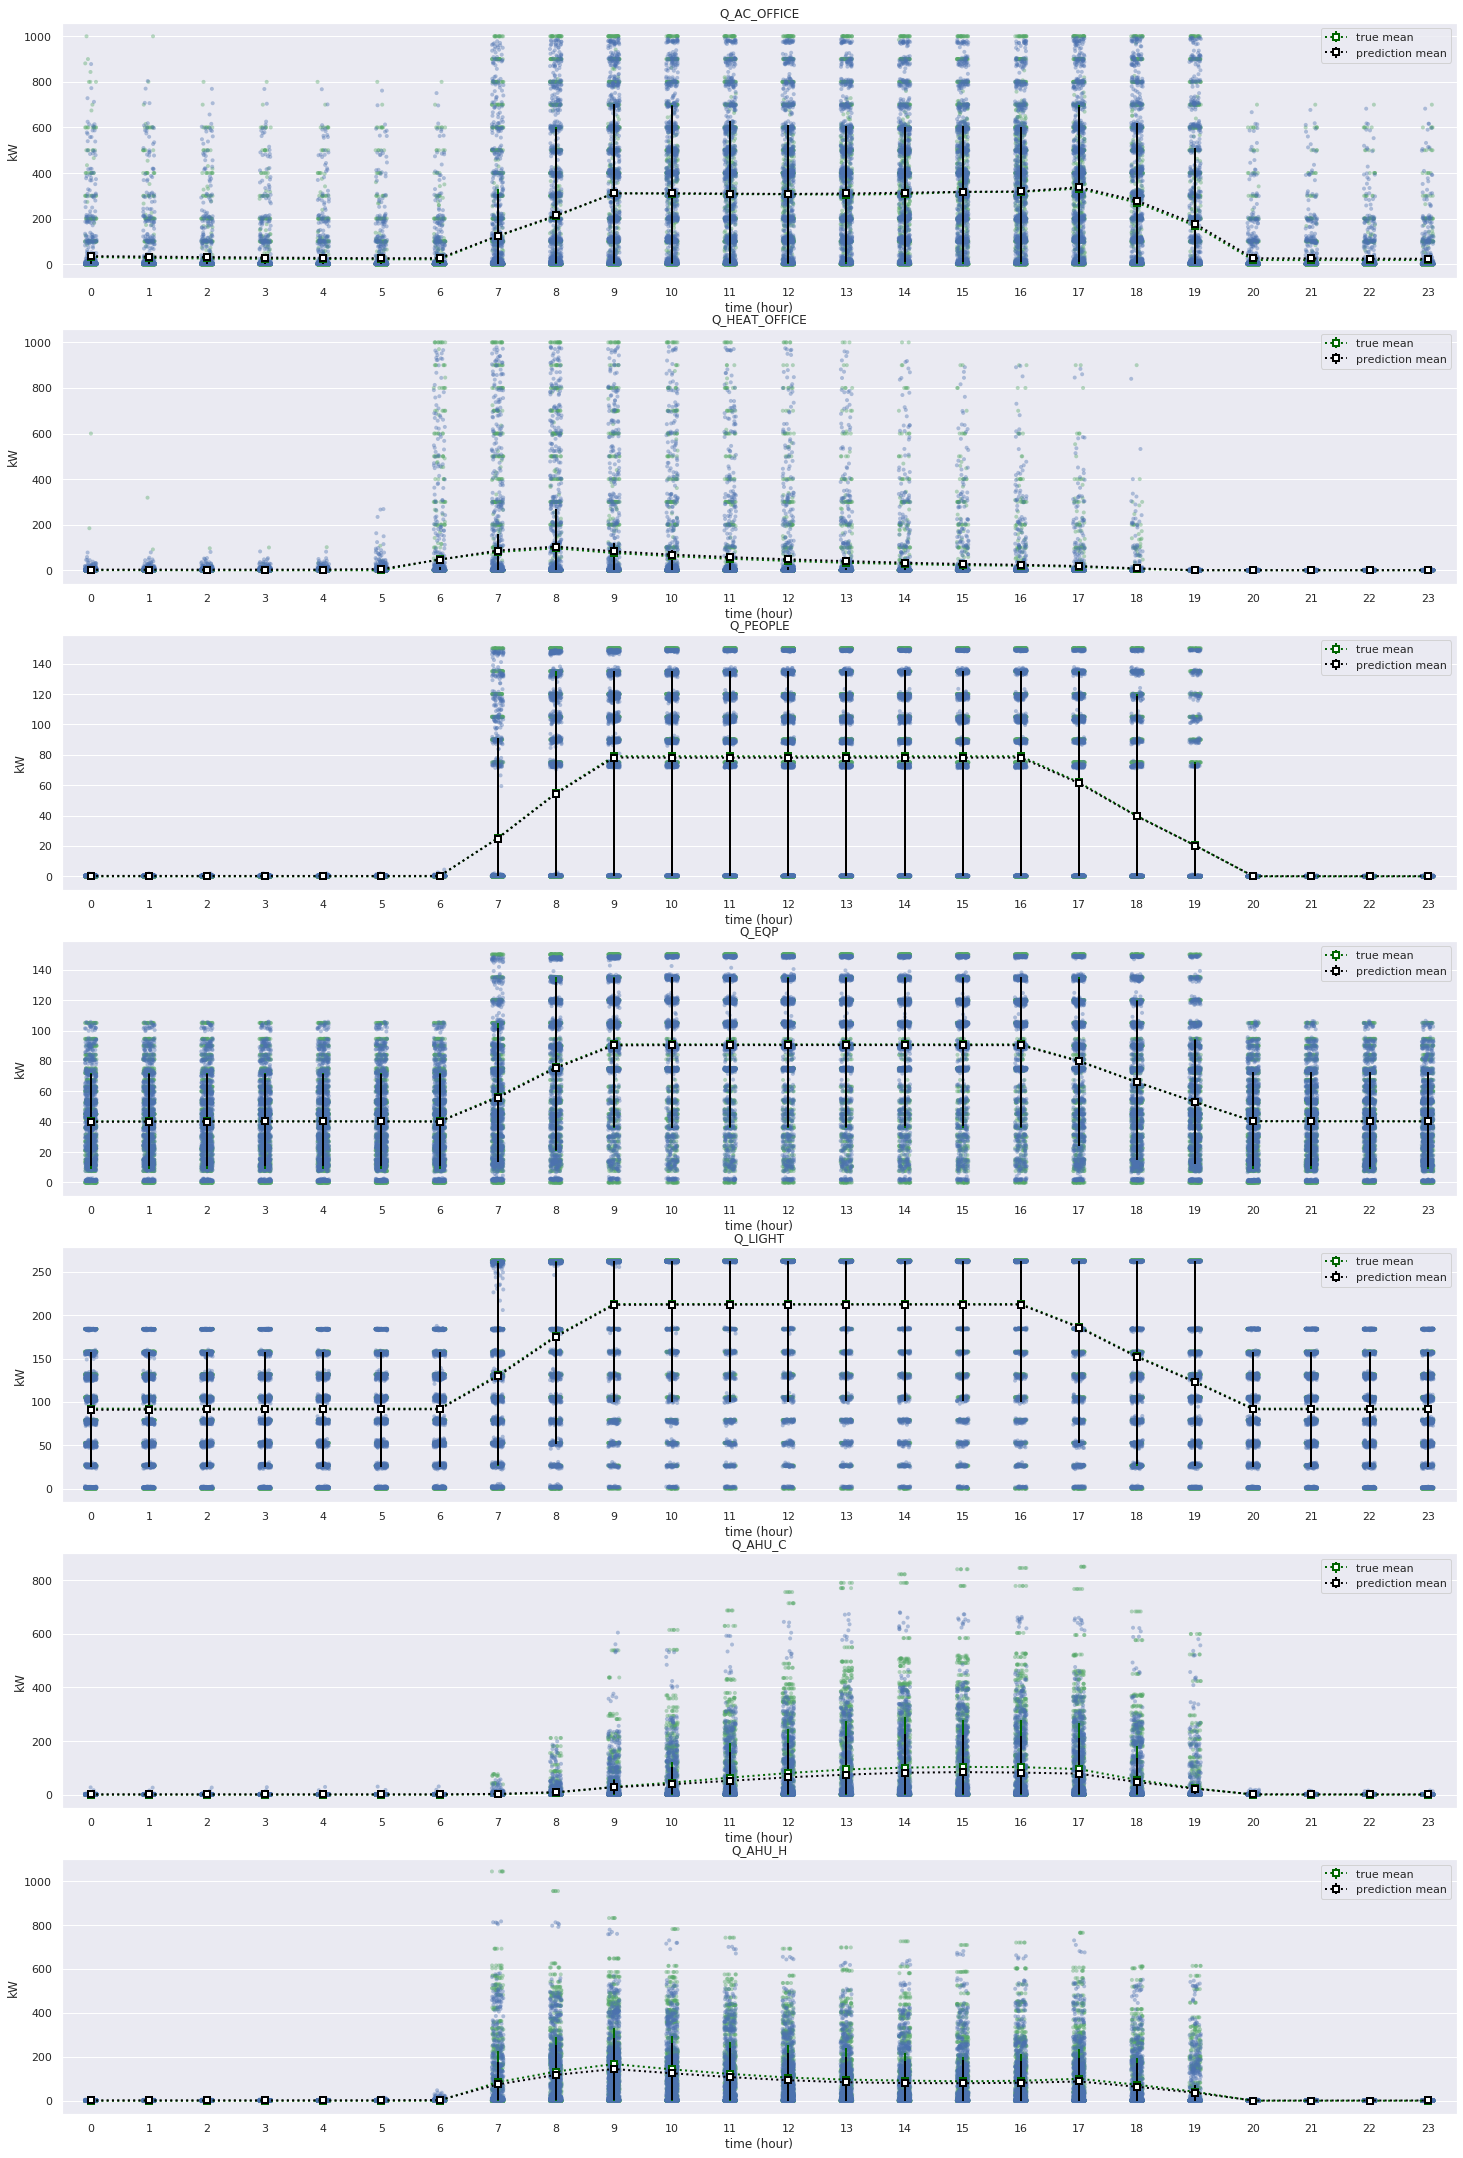

In [8]:
map_plot_function(ozeDataset, predictions, plot_values_distribution, time_limit=24, labels=['Q_AC_OFFICE',
                                                                                            'Q_HEAT_OFFICE',
                                                                                            'Q_PEOPLE',
                                                                                            'Q_EQP',
                                                                                            'Q_LIGHT',
                                                                                            'Q_AHU_C',
                                                                                            'Q_AHU_H'])

### Plot error distribution for temperature

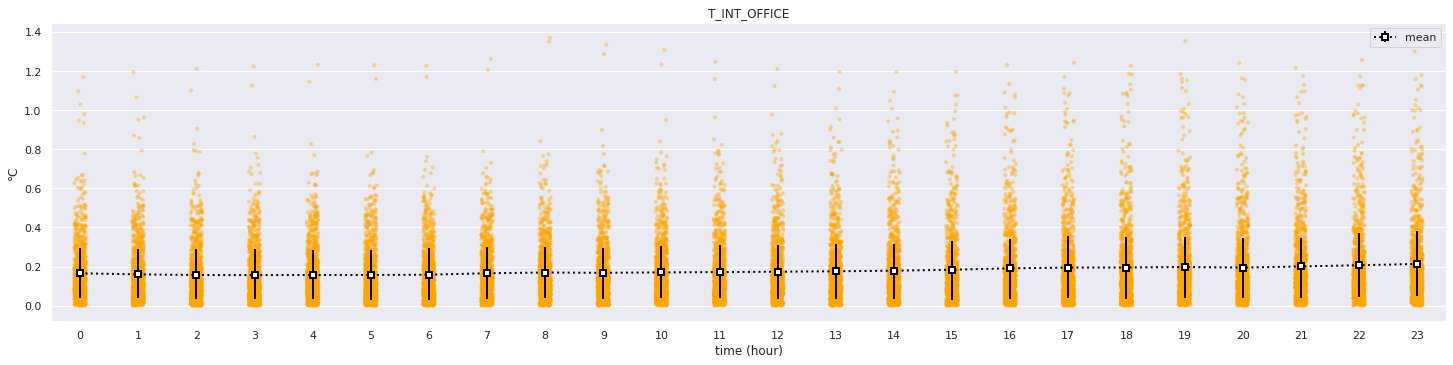

In [9]:
map_plot_function(ozeDataset, predictions, plot_error_distribution, labels=['T_INT_OFFICE'], time_limit=24)

### Plot mispredictions thresholds

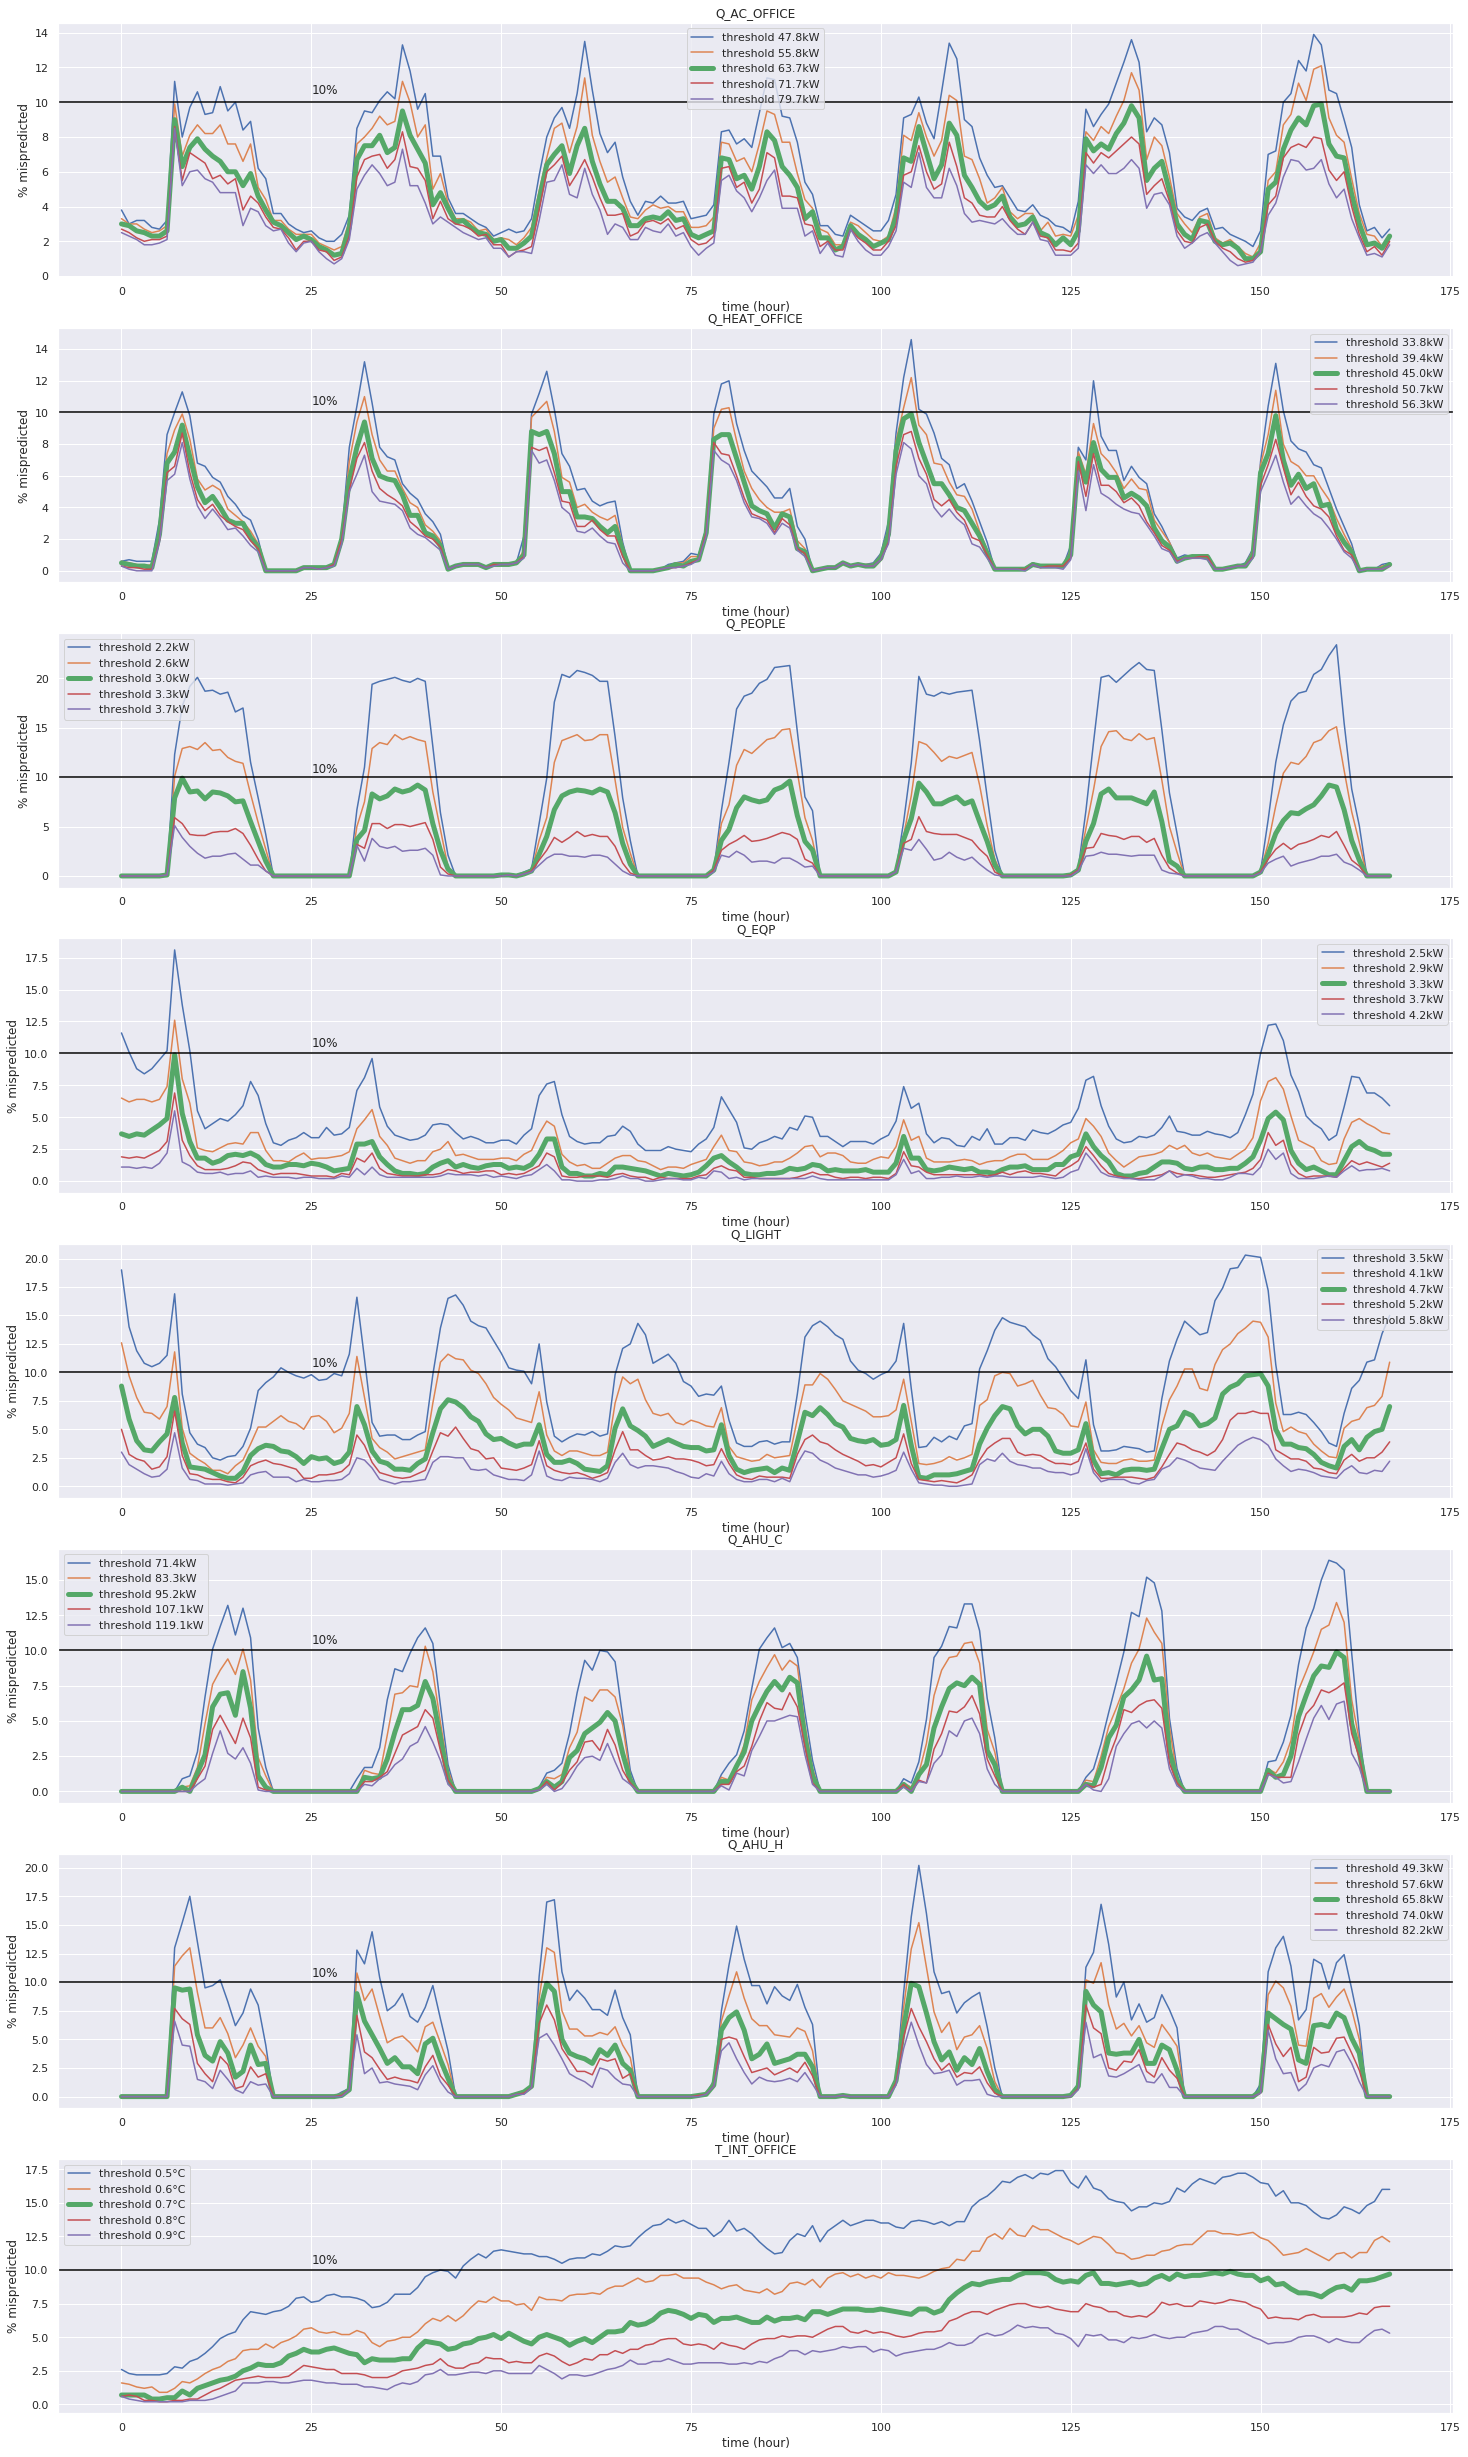

In [10]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, plot_kwargs={'error_band': 0.1})